In [1]:
import pyspark
from os import listdir
from os.path import isfile, join
import boto3
import pandas as pd
from sagemaker import get_execution_role
from pyspark.sql.types import LongType, StringType, StructField, StructType, BooleanType, ArrayType, IntegerType

# Initialize the spark environment (takes ~ 1min)

In [2]:
conf = pyspark.SparkConf().setAppName('odl').setMaster('local')
sc = pyspark.SparkContext(conf=conf)
sqlc = pyspark.sql.SQLContext(sc)
sc

<SparkContext master=local appName=odl>

In [3]:
sqlc

### Read into dataframe

In [4]:
dataPath = "wine.csv"
wine = sqlc.read.format("csv")\
    .option("header","true")\
    .option("inferSchema", "true")\
    .load(dataPath)

### Write parquet to s3

In [5]:
parquetPath = '/home/ec2-user/SageMaker/tmp-pqt-fy6vj'
wine.write.parquet(parquetPath)

In [6]:
# prep list of files to transfer
files = [f for f in listdir(parquetPath) if isfile(join(parquetPath, f))]

s3 = boto3.resource('s3')
bucket='odl-spark19spds6003-001'
for f in files:
    #print('copying {} to {}'.format(parquetPath+'/'+f,"sample_data/"+f))
    s3.Bucket(bucket).upload_file(parquetPath+'/'+f, "sample_data/pqt/"+f)

### Write to spark dataframe from parquet

In [7]:
wine = sqlc.read.parquet(parquetPath)

In [8]:
wine

DataFrame[fixed_acidity: double, volatile_acidity: double, citric_acid: double, residual_sugar: double, chlorides: double, free_sulfur_dioxide: double, total_sulfur_dioxide: double, density: double, pH: double, sulphates: double, alcohol: double, quality: int]

## Using MLlib

### Convention
* df = spark dataframe
* pddf = pandas dataframe

### Outline
1. make demo data frame
2. exploratory tools
3. feature engineering
4. train/test
5. vectorize (spark special sauce)
6. train
7. predict
8. eval

### Make a demo data frame

In [9]:
wine = wine.dropna() # spark thinks NaN are strings and the rest are doubles, so dropnas

## MLlib Basics
* exploratory tools


In [10]:
display(wine)

DataFrame[fixed_acidity: double, volatile_acidity: double, citric_acid: double, residual_sugar: double, chlorides: double, free_sulfur_dioxide: double, total_sulfur_dioxide: double, density: double, pH: double, sulphates: double, alcohol: double, quality: int]

In [11]:
wine.printSchema()

root
 |-- fixed_acidity: double (nullable = true)
 |-- volatile_acidity: double (nullable = true)
 |-- citric_acid: double (nullable = true)
 |-- residual_sugar: double (nullable = true)
 |-- chlorides: double (nullable = true)
 |-- free_sulfur_dioxide: double (nullable = true)
 |-- total_sulfur_dioxide: double (nullable = true)
 |-- density: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- sulphates: double (nullable = true)
 |-- alcohol: double (nullable = true)
 |-- quality: integer (nullable = true)



In [12]:
wine.take(3)

[Row(fixed_acidity=7.4, volatile_acidity=0.7, citric_acid=0.0, residual_sugar=1.9, chlorides=0.076, free_sulfur_dioxide=11.0, total_sulfur_dioxide=34.0, density=0.9978, pH=3.51, sulphates=0.56, alcohol=9.4, quality=5),
 Row(fixed_acidity=7.8, volatile_acidity=0.88, citric_acid=0.0, residual_sugar=2.6, chlorides=0.098, free_sulfur_dioxide=25.0, total_sulfur_dioxide=67.0, density=0.9968, pH=3.2, sulphates=0.68, alcohol=9.8, quality=5),
 Row(fixed_acidity=7.8, volatile_acidity=0.76, citric_acid=0.04, residual_sugar=2.3, chlorides=0.092, free_sulfur_dioxide=15.0, total_sulfur_dioxide=54.0, density=0.997, pH=3.26, sulphates=0.65, alcohol=9.8, quality=5)]

In [13]:
print("Pearson's r(fixed acidity, citric acid) = {}".format(wine.corr('fixed_acidity', 'citric_acid')))
print("Pearson's r(fixed acidity, sulphates) = {}".format(wine.corr('fixed_acidity', 'sulphates')))
print("Pearson's r(pH, quality) = {}".format(wine.corr('pH', 'quality')))

Pearson's r(fixed acidity, citric acid) = 0.6717034347641064
Pearson's r(fixed acidity, sulphates) = 0.18300566393215362
Pearson's r(pH, quality) = -0.05773139120538257


## ML
1. split data into train/test
2. **SPARK SPECIAL SAUCE** -  pysparki.ml.linalg - vectorization
3. Train --> Predict --> Evaluate

### Make Training and Test sets

In [14]:
# create train/test sets
seed = 42
(testDF, trainingDF) = wine.randomSplit((0.20, 0.80), seed=seed)
print ('training set N = {}, test set N = {}'.format(trainingDF.count(),testDF.count()))

training set N = 1289, test set N = 310


# VECTORIZATION - spark special sauce

In [15]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [16]:
assembler = VectorAssembler(
    inputCols = ["fixed_acidity", "volatile_acidity", "citric_acid", "residual_sugar", "chlorides", "free_sulfur_dioxide", \
                 "total_sulfur_dioxide", "density", "pH", "sulphates", "alcohol"],
    outputCol = "features")

trainingDF = assembler.transform(trainingDF)
testDF = assembler.transform(testDF)

In [17]:
# rename to make ML engine happy
trainingDF = trainingDF.withColumnRenamed("quality", "label")
testDF = testDF.withColumnRenamed("quality", "label")

In [18]:
trainingDF

DataFrame[fixed_acidity: double, volatile_acidity: double, citric_acid: double, residual_sugar: double, chlorides: double, free_sulfur_dioxide: double, total_sulfur_dioxide: double, density: double, pH: double, sulphates: double, alcohol: double, label: int, features: vector]

## ML time for real
1. Train
2. Predict
3. Evaluate

In [19]:
from pyspark.ml.regression import LinearRegression, LinearRegressionModel

lr = LinearRegression()
lrModel = lr.fit(trainingDF)

In [20]:
type(lrModel)

pyspark.ml.regression.LinearRegressionModel

Transform test set to get predictions. It will append a prediction column to testDF in the new dataframe predictionsAndLabelsDF.

In [21]:
predictionsAndLabelsDF = lrModel.transform(testDF)

print(predictionsAndLabelsDF.orderBy(predictionsAndLabelsDF.label.desc()).take(5))

[Row(fixed_acidity=7.4, volatile_acidity=0.36, citric_acid=0.3, residual_sugar=1.8, chlorides=0.074, free_sulfur_dioxide=17.0, total_sulfur_dioxide=24.0, density=0.99419, pH=3.24, sulphates=0.7, alcohol=11.4, label=8, features=DenseVector([7.4, 0.36, 0.3, 1.8, 0.074, 17.0, 24.0, 0.9942, 3.24, 0.7, 11.4]), prediction=6.2774816820952175), Row(fixed_acidity=6.6, volatile_acidity=0.815, citric_acid=0.02, residual_sugar=2.7, chlorides=0.072, free_sulfur_dioxide=17.0, total_sulfur_dioxide=34.0, density=0.9955, pH=3.58, sulphates=0.89, alcohol=12.3, label=7, features=DenseVector([6.6, 0.815, 0.02, 2.7, 0.072, 17.0, 34.0, 0.9955, 3.58, 0.89, 12.3]), prediction=6.05484019304761), Row(fixed_acidity=6.7, volatile_acidity=0.28, citric_acid=0.28, residual_sugar=2.4, chlorides=0.012, free_sulfur_dioxide=36.0, total_sulfur_dioxide=100.0, density=0.99064, pH=3.26, sulphates=0.39, alcohol=11.7, label=7, features=DenseVector([6.7, 0.28, 0.28, 2.4, 0.012, 36.0, 100.0, 0.9906, 3.26, 0.39, 11.7]), predicti

## Model Evaluation

In [22]:
from pyspark.ml.evaluation import RegressionEvaluator
eval = RegressionEvaluator()
print(eval.explainParams())

labelCol: label column name. (default: label)
metricName: metric name in evaluation - one of:
                       rmse - root mean squared error (default)
                       mse - mean squared error
                       r2 - r^2 metric
                       mae - mean absolute error. (default: rmse)
predictionCol: prediction column name. (default: prediction)


In [23]:
type(eval)

pyspark.ml.evaluation.RegressionEvaluator

In [24]:
eval.setMetricName("rmse").evaluate(predictionsAndLabelsDF)

0.6448136138074834

In [25]:
eval.setMetricName("r2").evaluate(predictionsAndLabelsDF)

0.38867367805578346

## Visualization

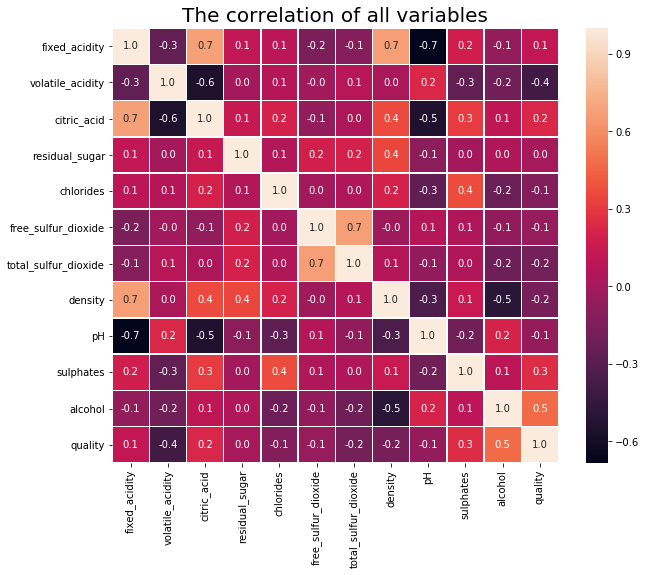

In [27]:
import qtconsole
import seaborn as sns
import matplotlib.pyplot as plt

wine = pd.read_csv("wine.csv")
f,ax = plt.subplots(figsize=(10,8))
sns.heatmap(wine.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.title("The correlation of all variables",size=20)           
plt.show()